In [1]:
import os
import sys

# 自动检测环境
IS_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ
competition_name = 'competitions/titanic'

if IS_KAGGLE:
    print("Running on Kaggle")
    DATA_PATH = '/kaggle/input/' + competition_name
    OUTPUT_PATH = '/kaggle/working'
    # 可能需要安装包
else:
    print("Running locally")
    DATA_PATH = './data'
    OUTPUT_PATH = './output'

Running locally


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler # 根据需要选用
import seaborn as sns
from scipy import stats


# 随机森林模型
from sklearn.ensemble import RandomForestClassifier  # 分类问题
# from sklearn.ensemble import RandomForestRegressor # 回归问题

# 模型评估
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
## 用来画有中文注释的pyplot的
import matplotlib


# 在创建图形之前设置字体
matplotlib.rcParams['font.family'] = 'sans-serif'
# macOS系统可用的中文字体（按优先级排序）
matplotlib.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'PingFang SC', 'STHeiti', 'Microsoft YaHei', 'WenQuanYi Micro Hei']
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 可选：查看哪些字体被实际使用
print("当前使用的字体列表:", matplotlib.rcParams['font.sans-serif'])
print("当前字体家族:", matplotlib.rcParams['font.family'])

当前使用的字体列表: ['Arial Unicode MS', 'PingFang SC', 'STHeiti', 'Microsoft YaHei', 'WenQuanYi Micro Hei']
当前字体家族: ['sans-serif']


In [4]:
# Add src directory to Python path and import model
if IS_KAGGLE:
    !git clone https://github.com/catathome0410/Titanic_practice.git
    import sys
    sys.path.append('/kaggle/working/Titanic_practice/src')
else:
    sys.path.append('./src')

from model import log_R_solver, NN_solver

In [5]:
train = pd.read_csv(DATA_PATH + '/train.csv')
test = pd.read_csv(DATA_PATH + '/test.csv')
Y_train = np.array(train['Survived'])
train = train.drop(['Survived'], axis = 1)

In [6]:
## 做个train / test set 对抗练习

train_test = pd.concat([train, test])

train_test = train_test.drop(['Embarked'], axis = 1)

In [7]:
# 添加数据来源标签
train['dataset'] = 'train'
test['dataset'] = 'test'

# 合并数据用于分析
combined = pd.concat([train, test], ignore_index=True)

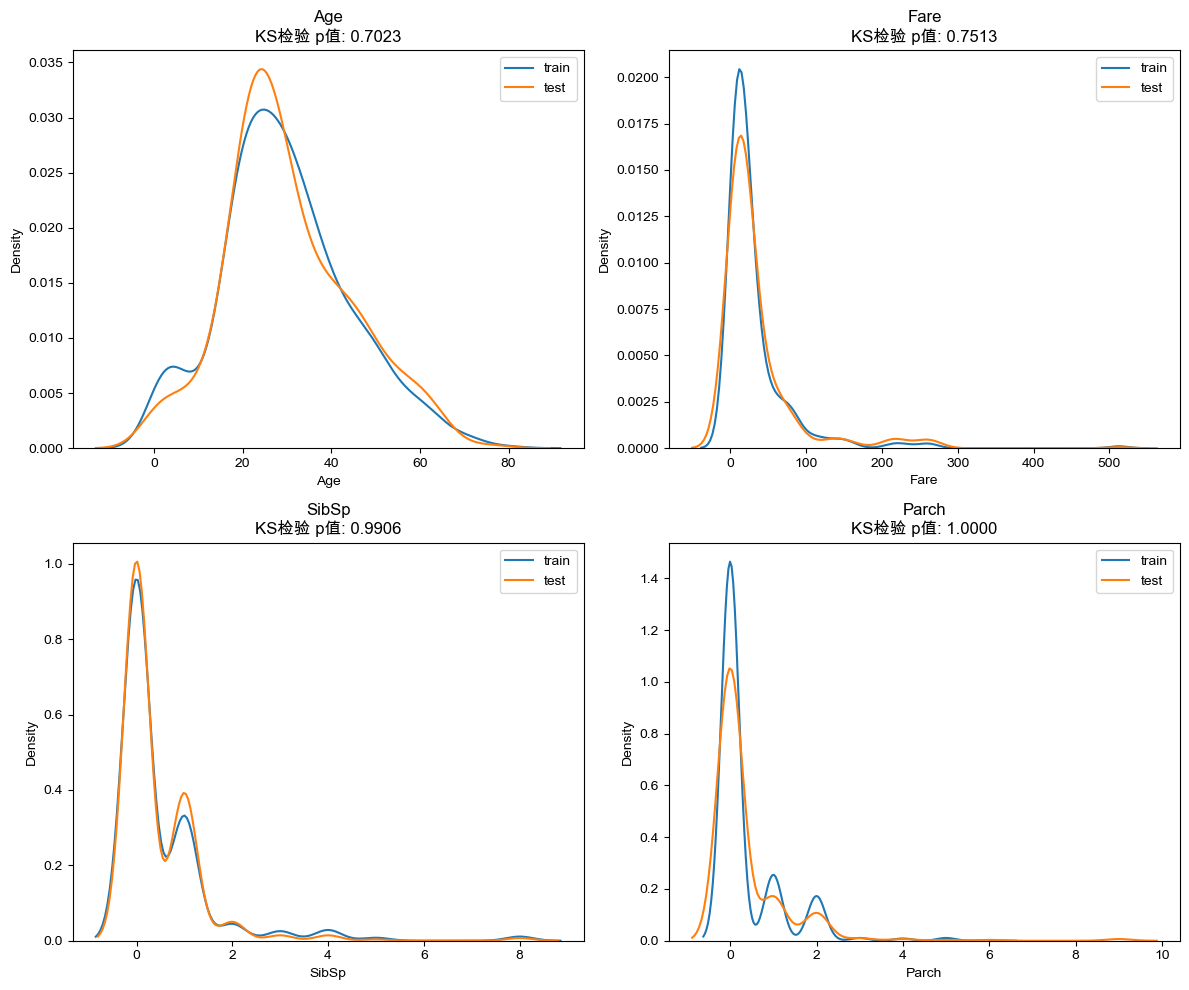

In [8]:
# 分析数值型特征的分布差异
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for idx, feature in enumerate(numerical_features):
    row, col = idx // 2, idx % 2
    
    # 绘制KDE分布
    for dataset in ['train', 'test']:
        data = combined[combined['dataset'] == dataset][feature].dropna()
        sns.kdeplot(data=data, label=dataset, ax=axes[row, col])
    
    # KS检验
    train_data = train[feature].dropna()
    test_data = test[feature].dropna()
    ks_stat, p_value = stats.ks_2samp(train_data, test_data)
    
    axes[row, col].set_title(f'{feature}\nKS检验 p值: {p_value:.4f}')
    axes[row, col].legend()

plt.tight_layout()
plt.show()



In [9]:
class Preprocessor_forT:
    def __init__(self):
        self.processor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), ['Age']),
                ('cat', OneHotEncoder(
                    sparse_output=False, 
                    handle_unknown='ignore',
                    dtype=np.int32), ['Pclass', 'name_title', 'Cabin_class', 'Fare_class'])
            ],
            remainder='passthrough'
        )

    def has_alias(self, row):
        str0 = row['Name']
        return str0.find('(') >= 0 or str0.find('"') >=0

    def double_family_name(self, row):
        str0 = row['Name']
        loc0 = str0.find(', ')
        loc1 = str0.find(' ')
        return loc1 < loc0

    def find_title(self, row):
        str0 = row['Name']
        loc0 = str0.find(', ')
        loc1 = str0.find('. ')
        return str0[loc0+2 : loc1]

    ## Fare : < 10, <32, <90, <200
    def fare_class(self, row):
        if row['Fare'] < 10:
            res = 'low'
        elif row['Fare'] < 32:
            res = 'midlow'
        elif row['Fare'] < 90:
            res = 'mid'
        elif row['Fare'] < 200:
            res = 'midhigh'
        else:
            res = 'high'
        return res

    def age_class(self, row):
        if row['Age'] < 1:
            res = 'unknown'
        elif row['Age'] <= 15:
            res = 'child'
        elif row['Age'] <= 25:
            res = 'teenager'
        elif row['Age'] <= 37:
            res = 'young'
        elif row['Age'] <= 50:
            res = 'midage'
        elif row['Age'] <= 65:
            res = '50s'
        else:
            res = 'old'
        return res
            

    def cabin_class(self, row):
        if row['Cabin'].find(' ') >= 0:
            res = 'S'
        else:
            res = row['Cabin'][0]
        return res

    def clean_transform(self, df):
        df_train = df.copy()
        # df_train['Embarked'] = df_train['Embarked'].fillna('S')
        df_train = df_train.drop(['Ticket'], axis = 1)
        df_train['name_title'] = df_train.apply(self.find_title, axis = 1)
        df_train['double_family_name'] = df_train.apply(self.double_family_name, axis = 1)
        df_train['has_alias'] = df_train.apply(self.has_alias, axis = 1)
        df_train['Age_present'] = df_train['Age'].isna() == False
        df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
        df_train['Age'] = df_train['Age'].fillna(0)
        df_train['Age_class'] = df_train.apply(self.age_class, axis = 1)
        df_train['name_title'] = df_train.apply(lambda row: row['name_title'] if row['name_title'] in ('Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev') else 'other', axis = 1)
        df_train['Cabin_present'] = df_train['Cabin'].isna() == False
        df_train['Fare_class'] = df_train.apply(self.fare_class, axis = 1)
        df_train['Cabin'] = df_train['Cabin'].fillna('None')
        df_train['Cabin_class'] = df_train.apply(self.cabin_class, axis = 1)
        df_train['Sex_male'] = df_train['Sex'] == 'male'
        df_train = df_train.drop(['Sex', 'Name', 'Cabin', 'PassengerId', 'Fare', 'Age'], axis = 1)
        df_train = df_train.astype({
            'double_family_name': 'int32',
            'has_alias': 'int32',
            'Age_present': 'int32',
            'Cabin_present': 'int32',
            'Sex_male': 'int32',
        })

        return df_train
        
    def fit_transform(self, df):
        self.df_processed = self.clean_transform(df)
        self.processor.fit(self.df_processed)
        df_res = self.processor.transform(self.df_processed)

        return df_res
        

In [10]:
prssr1 = Preprocessor_forT()
dfX_train_test = prssr1.clean_transform(train_test)
oneHotTsfm = ColumnTransformer(
    # transformers=[
    #     ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['Pclass', 'Embarked', 'name_title', 'Cabin_class', 'Fare_class', 'Age_class'])
    # ],
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['Pclass', 'name_title', 'Cabin_class', 'Fare_class', 'Age_class'])
    ],
    remainder='passthrough',  # 其他列保留不变
    verbose_feature_names_out=False
)
oneHotTsfm.set_output(transform='pandas')
dfX_train_test = oneHotTsfm.fit_transform(dfX_train_test)
dfX_train_test


,Pclass_1,Pclass_2,Pclass_3,name_title_Dr,name_title_Master,name_title_Miss,name_title_Mr,name_title_Mrs,name_title_Rev,name_title_other,...,Age_class_unknown,Age_class_young,SibSp,Parch,double_family_name,has_alias,Age_present,FamilySize,Cabin_present,Sex_male
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1,0,0,0,1,2,0,1
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1,0,0,1,1,2,1,0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0,0,0,0,1,1,0,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1,0,0,1,1,2,1,0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0,0,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0,0,0,0,0,1,0,1
414,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0,0,1,0,1,1,1,0
415,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,1,1,0,1
416,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0,0,0,0,0,1,0,1


In [11]:
Y_train_test = np.zeros((dfX_train_test.shape[0], 1))
Y_train_test[train_test['PassengerId'] > train.shape[0], 0] = 1
Y_train_test





array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], shape=(1309, 1))

In [12]:
rf_model = RandomForestClassifier(
    n_estimators=100,      # 森林中树木的数量，默认100
    max_depth=None,        # 树的最大深度，None表示不限制，直到叶子节点纯净
    min_samples_split=2,   # 内部节点再划分所需最小样本数
    min_samples_leaf=1,    # 叶子节点最少样本数
    random_state=42,       # 固定随机种子，保证结果可复现
    n_jobs=-1              # 使用所有可用的CPU核心，加速训练
)

In [13]:
rf_model.fit(dfX_train_test, Y_train_test)

# 查看模型在训练集上的准确率（不要太在意，可能有轻微过拟合）
train_accuracy = rf_model.score(dfX_train_test, Y_train_test)
print(f"训练集准确率: {train_accuracy:.4f}")

/Users/nanyidong/anaconda3/envs/pytorch_src/lib/python3.10/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


训练集准确率: 0.7983


AUC分数: 0.8675


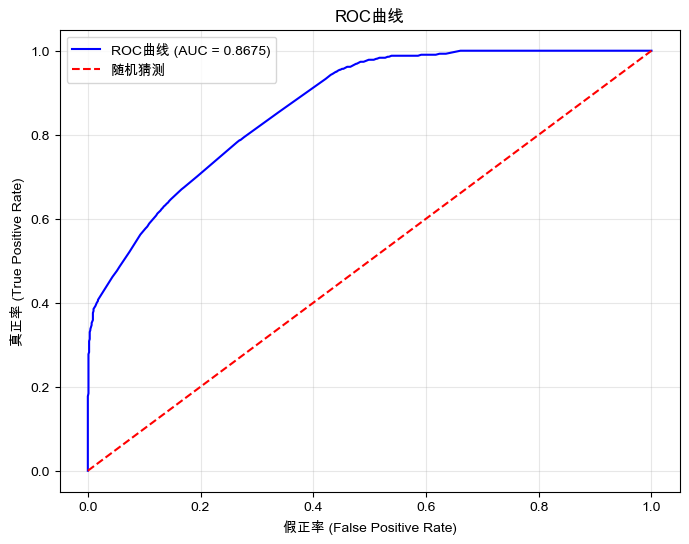

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 假设你已经训练好了模型
# rf_model.fit(X_train, y_train)

# 1. 获取预测概率（正类的概率）
y_pred_proba = rf_model.predict_proba(dfX_train_test)[:, 1]  # [:, 1] 取正类的概率

# 2. 计算AUC分数
auc_score = roc_auc_score(Y_train_test, y_pred_proba)
print(f"AUC分数: {auc_score:.4f}")

# 3. （可选）绘制ROC曲线
fpr, tpr, thresholds = roc_curve(Y_train_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', label=f'ROC曲线 (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'r--', label='随机猜测')
plt.xlabel('假正率 (False Positive Rate)')
plt.ylabel('真正率 (True Positive Rate)')
plt.title('ROC曲线')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
importances = rf_model.feature_importances_

# 创建DataFrame便于查看
feature_importance_df = pd.DataFrame({
    'feature': dfX_train_test.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

print("特征重要性排序:")
print(feature_importance_df)

特征重要性排序:
               feature  importance
37          FamilySize    0.111495
32               SibSp    0.086607
33               Parch    0.074052
35           has_alias    0.040556
27    Age_class_midage    0.039843
29  Age_class_teenager    0.037561
24   Fare_class_midlow    0.036785
31     Age_class_young    0.034746
22      Fare_class_mid    0.034491
2             Pclass_3    0.030472
6        name_title_Mr    0.027185
25       Age_class_50s    0.026702
34  double_family_name    0.026625
1             Pclass_2    0.026087
5      name_title_Miss    0.024590
7       name_title_Mrs    0.023712
39            Sex_male    0.023414
0             Pclass_1    0.023135
21      Fare_class_low    0.022470
36         Age_present    0.020879
30   Age_class_unknown    0.020344
23  Fare_class_midhigh    0.017975
12       Cabin_class_C    0.017674
26     Age_class_child    0.016643
20     Fare_class_high    0.015812
17       Cabin_class_N    0.015661
38       Cabin_present    0.015475
11       Ca

In [31]:
all_age_class_importance = feature_importance_df[feature_importance_df['feature'].str.startswith('Age_class_', na=False)]['importance'].sum()
print(f'age class importance sum = {all_age_class_importance:.4f}')
all_fare_class_importance = feature_importance_df[feature_importance_df['feature'].str.startswith('Fare_class_', na=False)]['importance'].sum()
print(f'fare class importance sum = {all_fare_class_importance:.4f}')
all_cabin_class_importance = feature_importance_df[feature_importance_df['feature'].str.startswith('Cabin_class_', na=False)]['importance'].sum()
print(f'cabin class importance sum = {all_cabin_class_importance:.4f}')
all_Pclass_class_importance = feature_importance_df[feature_importance_df['feature'].str.startswith('Pclass_', na=False)]['importance'].sum()
print(f'Pclass class importance sum = {all_Pclass_class_importance:.4f}')
print(f'all class importance sum = {feature_importance_df["importance"].sum():.4f}')

age class importance sum = 0.1835
fare class importance sum = 0.1275
cabin class importance sum = 0.1064
Pclass class importance sum = 0.0797
all class importance sum = 1.0000


In [16]:
dfX_train_test_A = prssr1.clean_transform(train_test)
dfX_train_test_A['From_Test'] = Y_train_test
dfX_train_test_A['From_Test'] = dfX_train_test_A.apply(lambda row: 'True' if row['From_Test'] == 1 else 'False', axis = 1)
dfX_train_test_A

,Pclass,SibSp,Parch,name_title,double_family_name,has_alias,Age_present,FamilySize,Age_class,Cabin_present,Fare_class,Cabin_class,Sex_male,From_Test
0,3,1,0,Mr,0,0,1,2,teenager,0,low,N,1,False
1,1,1,0,Mrs,0,1,1,2,midage,1,mid,C,0,False
2,3,0,0,Miss,0,0,1,1,young,0,low,N,0,False
3,1,1,0,Mrs,0,1,1,2,young,1,mid,C,0,False
4,3,0,0,Mr,0,0,1,1,young,0,low,N,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,0,0,Mr,0,0,0,1,unknown,0,low,N,1,True
414,1,0,0,other,1,0,1,1,midage,1,midhigh,C,0,True
415,3,0,0,Mr,0,0,1,1,midage,0,low,N,1,True
416,3,0,0,Mr,0,0,0,1,unknown,0,low,N,1,True


In [ ]:
from scipy.stats import chi2_contingency
df_chisq_test = pd.DataFrame(columns=['column_name', 'p_value'])
# col_names = ['Pclass', 'Embarked', 'name_title', 'double_family_name', 'has_alias', 'Age_present', 'Cabin_present', 'Age_class', 'Fare_class', 'Cabin_class', 'Sex_male']
col_names = ['Pclass', 'name_title', 'double_family_name', 'has_alias', 'Age_present', 'Cabin_present', 'Age_class', 'Fare_class', 'Cabin_class', 'Sex_male']


for i, col_name in enumerate(col_names):
    # 方法1：用pandas的crosstab创建列联表
    contingency_table = pd.crosstab(dfX_train_test_A[col_name], dfX_train_test_A['From_Test'])

    # 进行卡方检验
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    df_chisq_test.loc[i] = [col_name, p_value]

    print(f"\n卡方检验结果: {col_name}")
    print(f"p值: {p_value:.4f}")
    print()

print(df_chisq_test.sort_values('p_value'))

In [ ]:
print(df_chisq_test.sort_values('p_value'))

In [ ]:
prssr = Preprocessor_forT()
prssr.fit(train)
X_train = prssr.transform(train)
X_test = prssr.transform(test)


In [ ]:
n_pick_0 = np.floor(X_train.shape[0] / 16)
print(n_pick_0)
n_pick = 54 * 16

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=9, shuffle=True, random_state=42)

In [ ]:
# n_pick_arr = []
# avg_train_acc = []
# avg_dev_acc = []
# std_train_acc = []
# std_dev_acc = []

# for i in range(6):
#     n_pick = (i+1) * 9 * 16
#     # kf = KFold(n_splits=9, shuffle=True, random_state=42)
#     Xs = X_train[:n_pick, :]
#     Ys = Y_train[:n_pick]

#     kf = KFold(n_splits=9, shuffle=True)
#     model_accuracies_dev = []
#     model_accuracies_train = []

#     for train_idx, test_idx in kf.split(Xs):
#         Xss_train, Xss_test = Xs[train_idx], Xs[test_idx]
#         yss_train, yss_test = Ys[train_idx], Ys[test_idx]
        
#         model = log_R_solver(Xss_train, yss_train, alpha = 0.03, lambda2=0.01)
#         model.fit_L2()

#         y_train_pred = model.transfrom(Xss_train)
#         accuracy = np.sum(yss_train == y_train_pred) / yss_train.shape[0]
#         model_accuracies_train.append(accuracy)
        
#         y_test_pred = model.transfrom(Xss_test)
#         accuracy = np.sum(yss_test == y_test_pred) / yss_test.shape[0]
#         model_accuracies_dev.append(accuracy)

#     print(f"train 平均 accuracy: {np.mean(model_accuracies_train):.4f}")
#     print(f"train accuracy 标准差: {np.std(model_accuracies_train):.4f}")
#     print(f"dev 平均 accuracy: {np.mean(model_accuracies_dev):.4f}")
#     print(f"dev accuracy 标准差: {np.std(model_accuracies_dev):.4f}")

#     n_pick_arr.append(n_pick)
#     avg_train_acc.append(np.mean(model_accuracies_train))
#     avg_dev_acc.append(np.mean(model_accuracies_dev))
#     std_train_acc.append(np.std(model_accuracies_train))
#     std_dev_acc.append(np.std(model_accuracies_dev))


In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# # First subplot: y1 and y2
# ax1.plot(n_pick_arr, avg_train_acc, 'r-', linewidth=2, label='avg train acc')
# ax1.plot(n_pick_arr, avg_dev_acc, 'b--', linewidth=2, label='avg dev acc')
# ax1.set_xlabel('X axis', fontsize=12)
# ax1.set_ylabel('Y axis', fontsize=12)
# ax1.set_title('Plot 1: avg accuracy', fontsize=14)
# ax1.legend(fontsize=11)
# ax1.grid(True, alpha=0.3)

# # Second subplot: y3 and y4
# ax2.plot(n_pick_arr, std_train_acc, 'r-', linewidth=2, label='std train acc')
# ax2.plot(n_pick_arr, std_dev_acc, 'b--', linewidth=2, label='std dev acc')
# ax2.set_xlabel('X axis', fontsize=12)
# ax2.set_ylabel('Y axis', fontsize=12)
# ax2.set_title('Plot 2: std accuracy', fontsize=14)
# ax2.legend(fontsize=11)
# ax2.grid(True, alpha=0.3)

# fig.suptitle('alpha = 0.03, lambda2=0.01')
# plt.tight_layout()
# plt.show()

In [ ]:
# model_accuracies

In [ ]:
# LgR_model = log_R_solver(X_train, Y_train, alpha = 0.02, lambda2=0.01)
# LgR_model.fit_L2()

In [ ]:
# y_res_logr = LgR_model.transfrom(X_test)
# df_test_for_o = test.copy()
# df_test_for_o['Survived'] = y_res_logr
# df_res = df_test_for_o[['PassengerId', 'Survived']]
# df_res.to_csv(OUTPUT_PATH + 'v12_after_bv.csv', index=False, encoding='utf-8')


In [ ]:
if IS_KAGGLE == False:
    os.makedirs('output', exist_ok=True)


In [ ]:
# df_res = df_test[['PassengerId', 'Survived']]
# df_res.to_csv(OUTPUT_PATH + '/v4_l2_reg.csv', index=False, encoding='utf-8')

In [ ]:
# n_pick_0 = np.floor(X_train.shape[0] / 16)
# print(n_pick_0)
# n_pick = 54 * 16
# Xs = X_train[:n_pick, :]
# Ys = Y_train[:n_pick]

In [ ]:
n_pick_arr = []
avg_train_acc = []
avg_dev_acc = []
std_train_acc = []
std_dev_acc = []

for i in range(6):
    n_pick = (i+1) * 9 * 16
    Xs = X_train[:n_pick, :]
    Ys = Y_train[:n_pick]

    # kf = KFold(n_splits=9, shuffle=True, random_state=42)
    kf = KFold(n_splits=9, shuffle=True)
    model_accuracies_dev = []
    model_accuracies_train = []

    for train_idx, test_idx in kf.split(Xs):
        Xss_train, Xss_test = Xs[train_idx], Xs[test_idx]
        yss_train, yss_test = Ys[train_idx], Ys[test_idx]
        
        model = NN_solver(Xss_train, yss_train, alpha=0.02, lambda2 = 0.03, n_seed = 200, output_gap = 100)
        model.fit_shallow_parallel(shallow_iter_limit = 2000, target_loss = 320)

        n_min_seed = model.loss_arr.argmin()
        model.fit_deep(10000, lr_raito = 0.1, use_input = True, W1_i=model.W1[:, :, n_min_seed], b1_i=model.b1[:, :, n_min_seed], W2_i=model.W2[:, :, n_min_seed], b2_i=model.b2[:, :, n_min_seed], W3_i=model.W3[:, :, n_min_seed], b3_i=model.b3[:, :, n_min_seed])
        
        accuracy = model.check_performance(Xss_test, yss_test)
        model_accuracies_dev.append(accuracy)

        accuracy = model.check_performance(Xss_train, yss_train)
        model_accuracies_train.append(accuracy)

    n_pick_arr.append(n_pick)
    avg_train_acc.append(np.mean(model_accuracies_train))
    avg_dev_acc.append(np.mean(model_accuracies_dev))
    std_train_acc.append(np.std(model_accuracies_train))
    std_dev_acc.append(np.std(model_accuracies_dev))



In [ ]:
df = pd.DataFrame({
    'n_data': n_pick_arr,
    'avg_train_accuracy': avg_train_acc,
    'avg_dev_accuracy': avg_dev_acc,
    'std_train_accuracy': std_train_acc,
    'std_dev_accuracy': std_dev_acc
})

df.to_csv('nn_acc_curve_a002_l003.csv', index=False, encoding='utf-8')


In [ ]:
# y_res_logr = nslr.predict(X_test)
# df_test_for_o = test.copy()
# df_test_for_o['Survived'] = y_res_logr
# df_res = df_test_for_o[['PassengerId', 'Survived']]
# df_res.to_csv(OUTPUT_PATH + 'v14_nn_new_feature.csv', index=False, encoding='utf-8')

In [ ]:
# 就 NN的效果来说已经很好了，接下来要提升titanic 的数据效果是ML hyper parametr tuning 和feature engineering 方面的工作
    
    ## K-fold training, (check)
    ## Roc curve, precision / recall 
## 把Titanic 剩下的几个feature 挖出点东西来. Name / Cabin / 
## Bias / Variance curve
## NN variance tuning, 剪枝，regularization, early stopping 这些

for plotting b/v curves

In [ ]:
# df_bv_curve = pd.read_csv(OUTPUT_PATH + '/nn_acc_curve_a003.csv')
# df_bv_curve

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# # First subplot: y1 and y2
# ax1.plot(df_bv_curve[['n_data']], df_bv_curve[['avg_train_accuracy']], 'r-', linewidth=2, label='avg train acc')
# ax1.plot(df_bv_curve[['n_data']], df_bv_curve[['avg_dev_accuracy']], 'b--', linewidth=2, label='avg dev acc')
# ax1.set_xlabel('X axis', fontsize=12)
# ax1.set_ylabel('Y axis', fontsize=12)
# ax1.set_title('Plot 1: avg accuracy', fontsize=14)
# ax1.legend(fontsize=11)
# ax1.grid(True, alpha=0.3)

# # Second subplot: y3 and y4
# ax2.plot(df_bv_curve[['n_data']], df_bv_curve[['std_train_accuracy']], 'r-', linewidth=2, label='std train acc')
# ax2.plot(df_bv_curve[['n_data']], df_bv_curve[['std_dev_accuracy']], 'b--', linewidth=2, label='std dev acc')
# ax2.set_xlabel('X axis', fontsize=12)
# ax2.set_ylabel('Y axis', fontsize=12)
# ax2.set_title('Plot 2: std accuracy', fontsize=14)
# ax2.legend(fontsize=11)
# ax2.grid(True, alpha=0.3)

# fig.suptitle('alpha = 0.03')
# plt.tight_layout()
# plt.show()